In [33]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import shapiro, levene, mannwhitneyu
from scipy.stats import ttest_ind, norm, chi2_contingency

pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

import warnings
warnings.filterwarnings("ignore")


# Desactivar la notación científica en todo el DataFrame
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

# Objetivo del Ejercicio: Utilizando un conjunto de datos que hemos compartido, se busca evaluar si existen diferencias significativas en el número de vuelos
# reservados según el nivel educativo de los clientes. Para ello, los pasos que deberas seguir son:
    # 1. Preparación de Datos:
    # Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.
    # 2. Análisis Descriptivo:
    # Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, la desviación estandar, los percentiles) del número de vuelos reservados para cada grupo.
    # 3. Prueba Estadística:
    # Realiza una prueba de A/B testing para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos

In [5]:
df_final = pd.read_csv("files/df_final.csv", index_col = 0)

In [6]:
df_final.head()

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month,year_month,enrollment_year_month,cancellation_year_month
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,Unknown,Unknown,2017/1,2016/8,Unknown/Unknown
1,100102,2017,1,10,4,14,2030,203.0,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,NaN,Single,Nova,2887.74,Standard,2013,3,Unknown,Unknown,2017/1,2013/3,Unknown/Unknown
2,100140,2017,1,6,0,6,1200,120.0,0,0,Canada,British Columbia,Dawson Creek,U5I 4F1,Female,College,NaN,Divorced,Nova,2838.07,Standard,2016,7,Unknown,Unknown,2017/1,2016/7,Unknown/Unknown
3,100214,2017,1,0,0,0,0,0.0,0,0,Canada,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253.0,Married,Star,4170.57,Standard,2015,8,Unknown,Unknown,2017/1,2015/8,Unknown/Unknown
4,100272,2017,1,0,0,0,0,0.0,0,0,Canada,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163.0,Divorced,Star,6622.05,Standard,2014,1,Unknown,Unknown,2017/1,2014/1,Unknown/Unknown


In [8]:
df_filtrado = df_final[["loyalty_number", "flights_booked", "education"]]

In [9]:
df_filtrado.head()

,loyalty_number,flights_booked,education
0,100018,3,Bachelor
1,100102,10,College
2,100140,6,College
3,100214,0,Bachelor
4,100272,0,Bachelor


In [12]:
df_filtrado["education"].value_counts()

education
Bachelor                252567
College                 102260
High School or Below     18915
Doctor                   17731
Master                   12287
Name: count, dtype: int64

In [13]:
df_filtrado["education_level"] = df_filtrado["education"].apply(lambda dato: "Nivel alto" if dato in ["Doctor", "Master", "Bachelor"] else "Nivel bajo")
df_filtrado.head()

,loyalty_number,flights_booked,education,education_level
0,100018,3,Bachelor,Nivel alto
1,100102,10,College,Nivel bajo
2,100140,6,College,Nivel bajo
3,100214,0,Bachelor,Nivel alto
4,100272,0,Bachelor,Nivel alto


In [18]:
for col in df_filtrado["education_level"].unique():
    print(f"Educacion de {col}")
    print(df_filtrado[df_filtrado["education_level"] ==  col]["flights_booked"].describe())
    print("\n--------------------------------\n")

Educacion de Nivel alto
count    282585.000000
mean          4.118311
std           5.223592
min           0.000000
25%           0.000000
50%           1.000000
75%           8.000000
max          21.000000
Name: flights_booked, dtype: float64

--------------------------------

Educacion de Nivel bajo
count    121175.000000
mean          4.170753
std           5.244962
min           0.000000
25%           0.000000
50%           1.000000
75%           8.000000
max          21.000000
Name: flights_booked, dtype: float64

--------------------------------



In [ ]:
#Las metricas son muy parecidas en ambos grupos excepto el conteo que nos muestra que hay muchos mas clientes con un nivel alto de educacion

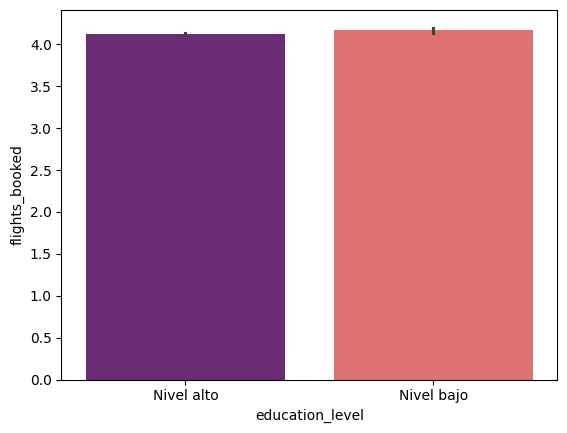

In [20]:
sns.barplot(x = "education_level", y = "flights_booked", data = df_filtrado, palette = "magma");
#aqui vemos las medias en un barplot

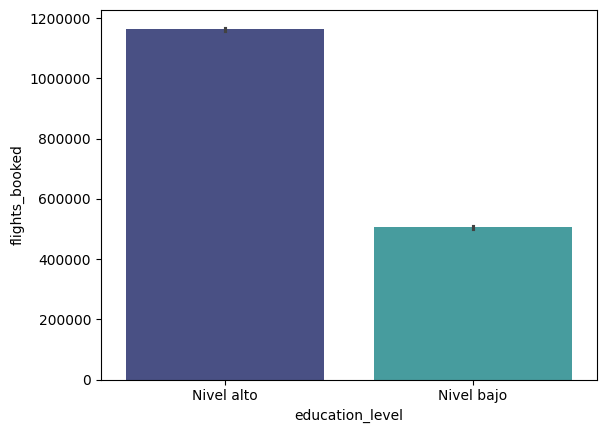

In [30]:
df = df_filtrado[["education_level", "flights_booked"]]
sns.barplot(x = "education_level", 
            y = "flights_booked",
              data = df, 
              palette = "mako", estimator = sum)

plt.ticklabel_format(style='plain', axis='y')
#usamos tambien un barplot para mostrar la suma del numero de vuelos reservados por cliente

In [ ]:
#Para realizar la prueba de A/B testing:

#Establecemos las hipotesis:
#   H0: No existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos
#   H1: Si existe una diferencia significativa

#si p_value < 0.05 -> rechazamos H0
#si p_value > 0.05 -> mantenemos H0

In [37]:
#1. Prueba de normalidad
#Establecemos las hipotesis:
#   H0: Los datos siguen una distribucion normal
#   H1: Los datos no siguen una distribucion normal

#si p_value < 0.05 -> rechazamos H0
#si p_value > 0.05 -> mantenemos H0

_,p_value = shapiro(df_filtrado['flights_booked'])
print(f"p-Value: {p_value}")

p-Value: 1.5469185716221557e-164


In [ ]:
# El p_value es negativo por lo que rechazamos H0, los datos no siguen una distribucion normal

In [ ]:
#Realizamos la prueba de Mann Whitney
#Establecemos las hipotesis:
#   H0: Los datos no son significativamente diferentes
#   H1: Los datos son significativamente diferentes

#si p_value < 0.05 -> rechazamos H0
#si p_value > 0.05 -> mantenemos H0

In [40]:
nivel_alto = df_filtrado[df_filtrado["education_level"] == "Nivel alto"]
nivel_bajo = df_filtrado[df_filtrado["education_level"] == "Nivel bajo"]

In [41]:
u_statistic, p_value = stats.mannwhitneyu(nivel_alto['flights_booked'], nivel_bajo['flights_booked'])
        
if p_value < 0.05:
    print(f"Las medianas son significativamente diferentes.")
else:
    print(f"Las medianas no son significativamente diferentes.")

Las medianas son significativamente diferentes.
